In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.9,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_09_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/735 [..............................] - ETA: 13:01 - loss: 0.3064 - STD: 1.3262e-04 - MAE: 0.5442

 12/735 [..............................] - ETA: 3s - loss: 0.0545 - STD: 1.6757e-04 - MAE: 0.1745   

 26/735 [>.............................] - ETA: 2s - loss: 0.0392 - STD: 8.1717e-05 - MAE: 0.1511

 40/735 [>.............................] - ETA: 2s - loss: 0.0295 - STD: 5.8492e-05 - MAE: 0.1283

 55/735 [=>............................] - ETA: 2s - loss: 0.0241 - STD: 4.4791e-05 - MAE: 0.1142

 70/735 [=>............................] - ETA: 2s - loss: 0.0210 - STD: 3.6551e-05 - MAE: 0.1060

 85/735 [==>...........................] - ETA: 2s - loss: 0.0189 - STD: 3.1101e-05 - MAE: 0.1006

100/735 [===>..........................] - ETA: 2s - loss: 0.0174 - STD: 2.7182e-05 - MAE: 0.0968

115/735 [===>..........................] - ETA: 2s - loss: 0.0164 - STD: 2.4348e-05 - MAE: 0.0940

130/735 [====>.........................] - ETA: 2s - loss: 0.0155 - STD: 2.2155e-05 - MAE: 0.0918

146/735 [====>.........................] - ETA: 2s - loss: 0.0148 - STD: 2.0406e-05 - MAE: 0.0900

162/735 [=====>........................] - ETA: 2s - loss: 0.0143 - STD: 1.9040e-05 - MAE: 0.0886

175/735 [======>.......................] - ETA: 1s - loss: 0.0139 - STD: 1.8145e-05 - MAE: 0.0875

187/735 [======>.......................] - ETA: 1s - loss: 0.0136 - STD: 1.7489e-05 - MAE: 0.0867

200/735 [=======>......................] - ETA: 1s - loss: 0.0133 - STD: 1.6872e-05 - MAE: 0.0860

214/735 [=======>......................] - ETA: 1s - loss: 0.0130 - STD: 1.6427e-05 - MAE: 0.0853

228/735 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 1.6122e-05 - MAE: 0.0847

235/735 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 1.6050e-05 - MAE: 0.0845

251/735 [=========>....................] - ETA: 2s - loss: 0.0125 - STD: 1.6029e-05 - MAE: 0.0839

267/735 [=========>....................] - ETA: 2s - loss: 0.0123 - STD: 1.6285e-05 - MAE: 0.0834

282/735 [==========>...................] - ETA: 2s - loss: 0.0121 - STD: 1.6657e-05 - MAE: 0.0830

296/735 [===========>..................] - ETA: 2s - loss: 0.0120 - STD: 1.7322e-05 - MAE: 0.0826

311/735 [===========>..................] - ETA: 2s - loss: 0.0119 - STD: 1.8415e-05 - MAE: 0.0823

327/735 [============>.................] - ETA: 1s - loss: 0.0117 - STD: 2.0284e-05 - MAE: 0.0820

343/735 [=============>................] - ETA: 1s - loss: 0.0116 - STD: 2.3145e-05 - MAE: 0.0816

358/735 [=============>................] - ETA: 1s - loss: 0.0115 - STD: 2.7069e-05 - MAE: 0.0814

373/735 [==============>...............] - ETA: 1s - loss: 0.0114 - STD: 3.2920e-05 - MAE: 0.0811

388/735 [==============>...............] - ETA: 1s - loss: 0.0113 - STD: 4.1745e-05 - MAE: 0.0809

404/735 [===============>..............] - ETA: 1s - loss: 0.0113 - STD: 5.6852e-05 - MAE: 0.0807

419/735 [================>.............] - ETA: 1s - loss: 0.0112 - STD: 8.0810e-05 - MAE: 0.0805

435/735 [================>.............] - ETA: 1s - loss: 0.0111 - STD: 1.2647e-04 - MAE: 0.0803

451/735 [=================>............] - ETA: 1s - loss: 0.0110 - STD: 2.1516e-04 - MAE: 0.0801

467/735 [==================>...........] - ETA: 1s - loss: 0.0110 - STD: 3.9822e-04 - MAE: 0.0799

484/735 [==================>...........] - ETA: 1s - loss: 0.0109 - STD: 7.8815e-04 - MAE: 0.0796

500/735 [===================>..........] - ETA: 1s - loss: 0.0108 - STD: 0.0015 - MAE: 0.0793    

516/735 [====================>.........] - ETA: 0s - loss: 0.0107 - STD: 0.0025 - MAE: 0.0789

532/735 [====================>.........] - ETA: 0s - loss: 0.0105 - STD: 0.0037 - MAE: 0.0784

548/735 [=====================>........] - ETA: 0s - loss: 0.0104 - STD: 0.0049 - MAE: 0.0779

563/735 [=====================>........] - ETA: 0s - loss: 0.0103 - STD: 0.0061 - MAE: 0.0775

578/735 [======================>.......] - ETA: 0s - loss: 0.0102 - STD: 0.0074 - MAE: 0.0770

593/735 [=======================>......] - ETA: 0s - loss: 0.0101 - STD: 0.0086 - MAE: 0.0765

609/735 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 0.0099 - MAE: 0.0760

625/735 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 0.0111 - MAE: 0.0754

640/735 [=========================>....] - ETA: 0s - loss: 0.0097 - STD: 0.0122 - MAE: 0.0750

656/735 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 0.0134 - MAE: 0.0745

672/735 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 0.0144 - MAE: 0.0741

688/735 [===========================>..] - ETA: 0s - loss: 0.0094 - STD: 0.0155 - MAE: 0.0736

704/735 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0165 - MAE: 0.0732

720/735 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0175 - MAE: 0.0727

735/735 [==============================] - 5s 5ms/step - loss: 0.0091 - STD: 0.0185 - MAE: 0.0723 - val_loss: 0.0041 - val_STD: 0.0423 - val_MAE: 0.0477


Epoch 2/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0539

 13/735 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0607 - MAE: 0.0536 

 26/735 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0535

 42/735 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0534

 58/735 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0533

 72/735 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0530

 87/735 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0530

103/735 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0528

119/735 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0527

134/735 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0527

148/735 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0527

161/735 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0527

176/735 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0526

190/735 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0524

202/735 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0523

216/735 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0522

232/735 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0521

248/735 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0520

264/735 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0520

279/735 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0519

294/735 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0518

307/735 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

323/735 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0518

339/735 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0517

354/735 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0517

368/735 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0516

383/735 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0516

399/735 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

413/735 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0514

424/735 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0514

439/735 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0513

455/735 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0513

470/735 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0512

486/735 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0511

501/735 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0511

517/735 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0510

534/735 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0510

547/735 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0509

561/735 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0509

577/735 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0509

589/735 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

601/735 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

614/735 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

626/735 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0507

638/735 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0507

649/735 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0506

663/735 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0506

677/735 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0506

690/735 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0505

702/735 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0505

715/735 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0505

731/735 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0504

735/735 [==============================] - 3s 4ms/step - loss: 0.0044 - STD: 0.0676 - MAE: 0.0504 - val_loss: 0.0034 - val_STD: 0.0547 - val_MAE: 0.0442


Epoch 3/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0481

 16/735 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0485 

 28/735 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0485

 42/735 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0483

 57/735 [=>............................] - ETA: 2s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0482

 72/735 [=>............................] - ETA: 2s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0482

 88/735 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0480

103/735 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0479

118/735 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

134/735 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0479

149/735 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

165/735 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

181/735 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

197/735 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

214/735 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

230/735 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

246/735 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

262/735 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

279/735 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

295/735 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

312/735 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

328/735 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

345/735 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

362/735 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

375/735 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

387/735 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

401/735 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

413/735 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

425/735 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0473

437/735 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0472

450/735 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0472

465/735 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0471

481/735 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0471

497/735 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

512/735 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

527/735 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

544/735 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

560/735 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

574/735 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

589/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

604/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

619/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

635/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

651/735 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

668/735 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

684/735 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

700/735 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

716/735 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0466

731/735 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0466

735/735 [==============================] - 3s 4ms/step - loss: 0.0038 - STD: 0.0724 - MAE: 0.0466 - val_loss: 0.0033 - val_STD: 0.0553 - val_MAE: 0.0423


Epoch 4/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0036 - STD: 0.0710 - MAE: 0.0452

 13/735 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447 

 25/735 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

 38/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

 53/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0447

 65/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0447

 77/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

 89/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

102/735 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

115/735 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

130/735 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

145/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

158/735 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

169/735 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

181/735 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

195/735 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

208/735 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0445

220/735 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

233/735 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0445

245/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

259/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0445

272/735 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0445

284/735 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

297/735 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

308/735 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

320/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

332/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

346/735 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

361/735 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

376/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

391/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

406/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

421/735 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

434/735 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

446/735 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

460/735 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

475/735 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

489/735 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

504/735 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

520/735 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

536/735 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

552/735 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

566/735 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

581/735 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

597/735 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

613/735 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

628/735 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

644/735 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

660/735 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

676/735 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

692/735 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

708/735 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

723/735 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

735/735 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

735/735 [==============================] - 3s 4ms/step - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440 - val_loss: 0.0031 - val_STD: 0.0580 - val_MAE: 0.0409


Epoch 5/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0434

 13/735 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0432 

 25/735 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0429

 40/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

 53/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

 66/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

 78/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

 90/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0425

103/735 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

117/735 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

133/735 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

149/735 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

164/735 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

180/735 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

195/735 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

210/735 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

225/735 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

240/735 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

255/735 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

271/735 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

283/735 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

295/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

307/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

322/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

336/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

350/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

365/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

381/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

395/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

407/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

419/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

432/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

446/735 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

458/735 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

470/735 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

481/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

495/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

506/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

518/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

531/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

542/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

554/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

567/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

582/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

597/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

611/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

626/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

640/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

656/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

672/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

688/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

703/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

718/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

733/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

735/735 [==============================] - 3s 4ms/step - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423 - val_loss: 0.0040 - val_STD: 0.0553 - val_MAE: 0.0451


Epoch 6/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0039 - STD: 0.0656 - MAE: 0.0446

 13/735 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0444 

 25/735 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

 37/735 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

 49/735 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

 61/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

 73/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

 86/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

 97/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

108/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

122/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

136/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

148/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

160/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

174/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

190/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

206/735 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

222/735 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

238/735 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

254/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

270/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

286/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

302/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

318/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

333/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

349/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

366/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

381/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

396/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

412/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

427/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

442/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

456/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

471/735 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

486/735 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

500/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

516/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

531/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

544/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

560/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

576/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0417

591/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

607/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

622/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

638/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

655/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

671/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

687/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

703/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

719/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

735/735 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415 - val_loss: 0.0030 - val_STD: 0.0661 - val_MAE: 0.0406


Epoch 7/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0407

 16/735 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0412 

 32/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

 47/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0408

 62/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0408

 78/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

 94/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

110/735 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

125/735 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

141/735 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

157/735 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

173/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

187/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

203/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

218/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

234/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

251/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

267/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

284/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

300/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

315/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

330/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

346/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

362/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

378/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

392/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

408/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

423/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

438/735 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

453/735 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

468/735 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

483/735 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

498/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

514/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

527/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

539/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

551/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

562/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

574/735 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

588/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

602/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

615/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

627/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

639/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

654/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

668/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

680/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

692/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

704/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

718/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

733/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

735/735 [==============================] - 3s 4ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403 - val_loss: 0.0029 - val_STD: 0.0645 - val_MAE: 0.0395


Epoch 8/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0387

 14/735 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0392 

 29/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0396

 46/735 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

 62/735 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

 77/735 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

 93/735 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0400

110/735 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

125/735 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

140/735 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

155/735 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

170/735 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

185/735 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

200/735 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

215/735 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

230/735 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

246/735 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

261/735 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

275/735 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

291/735 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

307/735 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

323/735 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

338/735 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

354/735 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

369/735 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

384/735 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

399/735 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

413/735 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

427/735 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

443/735 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

459/735 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

475/735 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

490/735 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

505/735 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

520/735 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

535/735 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

550/735 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

566/735 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

581/735 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

597/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

613/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

629/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

644/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

660/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

677/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

692/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

707/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

722/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

735/735 [==============================] - 3s 4ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398 - val_loss: 0.0029 - val_STD: 0.0652 - val_MAE: 0.0391


Epoch 9/10000


  1/735 [..............................] - ETA: 19s - loss: 0.0026 - STD: 0.0782 - MAE: 0.0368

 14/735 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0779 - MAE: 0.0386 

 30/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0782 - MAE: 0.0388

 47/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

 63/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

 78/735 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

 94/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0791 - MAE: 0.0388

111/735 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0792 - MAE: 0.0388

128/735 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

145/735 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

161/735 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

177/735 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

193/735 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

209/735 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

225/735 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

240/735 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

255/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

269/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

284/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

299/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

315/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

331/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

346/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

362/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

379/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

395/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

411/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

427/735 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

443/735 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

459/735 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

476/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

493/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

509/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

525/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

541/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

557/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

574/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

590/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

606/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

622/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

637/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

652/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

668/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

684/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

701/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

718/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

735/735 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

735/735 [==============================] - 3s 4ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389 - val_loss: 0.0029 - val_STD: 0.0678 - val_MAE: 0.0391


Epoch 10/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0024 - STD: 0.0836 - MAE: 0.0362

 15/735 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380 

 31/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

 47/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

 63/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

 78/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

 93/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

109/735 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

125/735 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

142/735 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

159/735 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0384

176/735 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

193/735 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

210/735 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

226/735 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

242/735 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

259/735 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

275/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

290/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

305/735 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

321/735 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

337/735 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

353/735 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

369/735 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

385/735 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

402/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

417/735 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

433/735 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

448/735 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

464/735 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

479/735 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

495/735 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

510/735 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

525/735 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

541/735 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

557/735 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

573/735 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

588/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

603/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

618/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

633/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

648/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

664/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

679/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

694/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

710/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

725/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

735/735 [==============================] - 3s 4ms/step - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381 - val_loss: 0.0030 - val_STD: 0.0724 - val_MAE: 0.0401


Epoch 11/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0026 - STD: 0.0878 - MAE: 0.0384

 16/735 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0819 - MAE: 0.0386 

 30/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0816 - MAE: 0.0381

 46/735 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0380

 61/735 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0377

 76/735 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0376

 89/735 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0375

101/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

112/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

125/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

141/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

156/735 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

171/735 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

186/735 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

201/735 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

216/735 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

232/735 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

247/735 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

263/735 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

279/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

295/735 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

311/735 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

327/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

343/735 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

359/735 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

376/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

392/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

408/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

425/735 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

440/735 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

456/735 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

472/735 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

489/735 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

506/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

522/735 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

538/735 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

554/735 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

569/735 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

585/735 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

600/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

615/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

630/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

645/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

660/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

675/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

690/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

705/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

718/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

732/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

735/735 [==============================] - 3s 4ms/step - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374 - val_loss: 0.0029 - val_STD: 0.0722 - val_MAE: 0.0391


Epoch 12/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0024 - STD: 0.0863 - MAE: 0.0369

 17/735 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0809 - MAE: 0.0364 

 33/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

 48/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0364

 63/735 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0812 - MAE: 0.0365

 75/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0812 - MAE: 0.0365

 90/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0364

102/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0364

116/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0365

131/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0365

146/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0813 - MAE: 0.0365

162/735 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

175/735 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

188/735 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

200/735 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

213/735 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

224/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

236/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

249/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

261/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

273/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

288/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

303/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

319/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

334/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

349/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

364/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

379/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

393/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

406/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

420/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

435/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

452/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

468/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

483/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

498/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

513/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

528/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

544/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

560/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

576/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

591/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

606/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

621/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

637/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

652/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

668/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

684/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

699/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

714/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

729/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

735/735 [==============================] - 3s 4ms/step - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366 - val_loss: 0.0033 - val_STD: 0.0744 - val_MAE: 0.0420


Epoch 13/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0028 - STD: 0.0864 - MAE: 0.0401

 15/735 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0827 - MAE: 0.0372 

 30/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0363

 44/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0363

 57/735 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0362

 70/735 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

 85/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

100/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

112/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

126/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

140/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

152/735 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

164/735 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

176/735 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

188/735 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

202/735 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

215/735 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

229/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0364

242/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

256/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

268/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

282/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

294/735 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

307/735 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

323/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

338/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

351/735 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

366/735 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

382/735 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

397/735 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

413/735 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

430/735 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

447/735 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

464/735 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

479/735 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

492/735 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

506/735 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

520/735 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

535/735 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

550/735 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

566/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

581/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

596/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

611/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

626/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

641/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

655/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

668/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

683/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

698/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

713/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

729/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

735/735 [==============================] - 3s 4ms/step - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360 - val_loss: 0.0029 - val_STD: 0.0691 - val_MAE: 0.0391


Epoch 14/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0023 - STD: 0.0766 - MAE: 0.0346

 14/735 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359 

 27/735 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0816 - MAE: 0.0354

 40/735 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0817 - MAE: 0.0356

 53/735 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0355

 65/735 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0354

 80/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0354

 95/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0353

110/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

124/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

140/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

156/735 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

172/735 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0357

187/735 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

201/735 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0356

217/735 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

232/735 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

247/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

262/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

277/735 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

292/735 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

305/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

318/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

330/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

345/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

360/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

375/735 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

387/735 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

399/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

414/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

429/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

444/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

459/735 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0356

474/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0356

489/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0356

505/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0356

522/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0356

539/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0356

555/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

571/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

588/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

605/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

620/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

636/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

651/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

666/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

681/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

697/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

714/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

730/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

735/735 [==============================] - 3s 4ms/step - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355 - val_loss: 0.0031 - val_STD: 0.0702 - val_MAE: 0.0402


Epoch 15/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0026 - STD: 0.0828 - MAE: 0.0363

 15/735 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0353 

 30/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0351

 45/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

 61/735 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0350

 76/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0349

 91/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

106/735 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

121/735 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0348

136/735 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0348

151/735 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0347

166/735 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0348

181/735 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0348

197/735 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0348

213/735 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0348

229/735 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0348

244/735 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0348

259/735 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0348

274/735 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0349

286/735 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0349

298/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0349

311/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0349

326/735 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0349

342/735 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0349

358/735 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0350

373/735 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0350

389/735 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0350

401/735 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0350

412/735 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0350

424/735 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0350

437/735 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0350

451/735 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0349

468/735 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0349

482/735 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0349

497/735 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0349

512/735 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0349

526/735 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

540/735 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

553/735 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

567/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

583/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

598/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

613/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

628/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

644/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

657/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

670/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

682/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

694/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

705/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

717/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

729/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

735/735 [==============================] - 3s 4ms/step - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348 - val_loss: 0.0029 - val_STD: 0.0726 - val_MAE: 0.0389


Epoch 16/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0340

 15/735 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0335 

 31/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0339

 46/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

 59/735 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0350

 75/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0350

 91/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

108/735 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

124/735 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

139/735 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0349

155/735 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

171/735 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

184/735 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

199/735 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

214/735 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

229/735 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

242/735 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

254/735 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

269/735 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

285/735 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

301/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

317/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

332/735 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

347/735 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

363/735 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

379/735 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

395/735 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

410/735 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

425/735 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

441/735 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

456/735 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

469/735 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

482/735 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

498/735 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

513/735 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

529/735 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

545/735 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

562/735 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

578/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

593/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

609/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

624/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

639/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

655/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

671/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

686/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

700/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

713/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

725/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

735/735 [==============================] - 3s 4ms/step - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343 - val_loss: 0.0031 - val_STD: 0.0758 - val_MAE: 0.0399


Epoch 17/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0021 - STD: 0.0903 - MAE: 0.0343

 15/735 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0340 

 31/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0335

 47/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0336

 63/735 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

 79/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

 95/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

111/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

127/735 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

142/735 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

157/735 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

173/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

188/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

203/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

218/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

234/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0341

249/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

264/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

279/735 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

294/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

309/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0339

324/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0339

339/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

354/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

370/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

386/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

402/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

419/735 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

435/735 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

451/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

466/735 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

481/735 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

496/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

511/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

526/735 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

541/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

556/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

572/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

587/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

602/735 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

618/735 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

632/735 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

648/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

664/735 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

679/735 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

695/735 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

711/735 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

727/735 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

735/735 [==============================] - 3s 4ms/step - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337 - val_loss: 0.0030 - val_STD: 0.0741 - val_MAE: 0.0396


Epoch 18/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0022 - STD: 0.0905 - MAE: 0.0325

 17/735 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.0854 - MAE: 0.0327 

 33/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0333

 49/735 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0848 - MAE: 0.0336

 65/735 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0848 - MAE: 0.0338

 80/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0847 - MAE: 0.0338

 94/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0845 - MAE: 0.0337

110/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0336

126/735 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0336

142/735 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0337

157/735 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0336

172/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0337

188/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0338

204/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0339

219/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0339

234/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

250/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

263/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

277/735 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

292/735 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

306/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

321/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

337/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

353/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0337

368/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

383/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0337

399/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0337

415/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

431/735 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

445/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

460/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

476/735 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

491/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

504/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0335

516/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0335

529/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0335

545/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0335

561/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0334

577/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0334

592/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0334

605/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

620/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

635/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

651/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

667/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

684/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

701/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

717/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

732/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

735/735 [==============================] - 3s 4ms/step - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332 - val_loss: 0.0030 - val_STD: 0.0732 - val_MAE: 0.0399


Epoch 19/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0019 - STD: 0.0917 - MAE: 0.0319

 16/735 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0326 

 31/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0328

 46/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

 62/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0335

 77/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0334

 91/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0332

107/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0332

123/735 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0332

138/735 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0331

153/735 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

168/735 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

183/735 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0329

199/735 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0329

216/735 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0329

233/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0329

250/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0328

266/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0328

283/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0330

299/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

314/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

329/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

345/735 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

362/735 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

378/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

395/735 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

411/735 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0329

427/735 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

443/735 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0329

459/735 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

474/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

490/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

506/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0329

522/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0329

538/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0329

555/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0329

571/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

586/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

603/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

620/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

636/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

652/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

669/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

685/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

701/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

718/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

734/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

735/735 [==============================] - 3s 4ms/step - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328 - val_loss: 0.0030 - val_STD: 0.0703 - val_MAE: 0.0397


Epoch 20/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0021 - STD: 0.0866 - MAE: 0.0333

 12/735 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0325 

 23/735 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.0859 - MAE: 0.0324

 36/735 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0323

 48/735 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0322

 60/735 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0321

 72/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

 84/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

 98/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

111/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0320

123/735 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

135/735 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

148/735 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

160/735 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

173/735 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

189/735 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

203/735 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

217/735 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

231/735 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

246/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

258/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

270/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

283/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

296/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

309/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

325/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

341/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

356/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

372/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

388/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

404/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

420/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

437/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

452/735 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

467/735 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

482/735 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

498/735 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

513/735 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

529/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

545/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

561/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

577/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

594/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

610/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

627/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

644/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

661/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

678/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

695/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

712/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

729/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

735/735 [==============================] - 3s 4ms/step - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323 - val_loss: 0.0029 - val_STD: 0.0751 - val_MAE: 0.0392


Epoch 21/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0018 - STD: 0.0910 - MAE: 0.0317

 12/735 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0318 

 26/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0318

 41/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0317

 56/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0320

 72/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0322

 88/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0321

103/735 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0320

119/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0320

135/735 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0320

150/735 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0319

165/735 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0318

179/735 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0318

191/735 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0318

206/735 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

221/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0318

237/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

253/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

269/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

285/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

300/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

316/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

331/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

346/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

358/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

371/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0319

387/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0319

403/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0319

419/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0319

434/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0319

450/735 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0319

466/735 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

482/735 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0319

498/735 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0320

514/735 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0320

530/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

543/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

557/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

570/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0319

586/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0319

602/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

617/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

632/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

647/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

662/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

678/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

693/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

709/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

725/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

735/735 [==============================] - 3s 4ms/step - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317 - val_loss: 0.0031 - val_STD: 0.0726 - val_MAE: 0.0403


Epoch 22/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0020 - STD: 0.0907 - MAE: 0.0345

 13/735 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0864 - MAE: 0.0311 

 27/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0867 - MAE: 0.0315

 42/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0863 - MAE: 0.0314

 55/735 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0314

 69/735 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

 82/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

 96/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

112/735 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

125/735 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

137/735 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

150/735 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0315

165/735 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0315

178/735 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

194/735 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

209/735 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

224/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

239/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

255/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

271/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

287/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

303/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

319/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

335/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

351/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

364/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

376/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

388/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0315

401/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

417/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

433/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

447/735 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

459/735 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

475/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

491/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

506/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

518/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

531/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

544/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

557/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

571/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

585/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

597/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

612/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

628/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

644/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

660/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

674/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

686/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

699/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

714/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

726/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

735/735 [==============================] - 3s 4ms/step - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313 - val_loss: 0.0030 - val_STD: 0.0684 - val_MAE: 0.0402


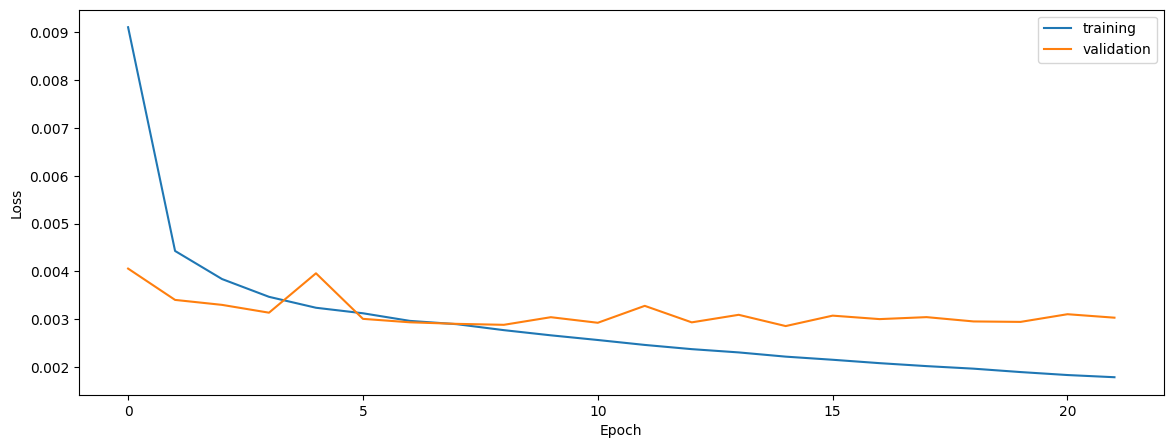

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8801951694663593
0.8285487418616952
0.8250409059996138


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8801951694663593
0.8285487418616952
0.8250409059996138


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.879214754338997
0.8266643631557766
0.824549878113704


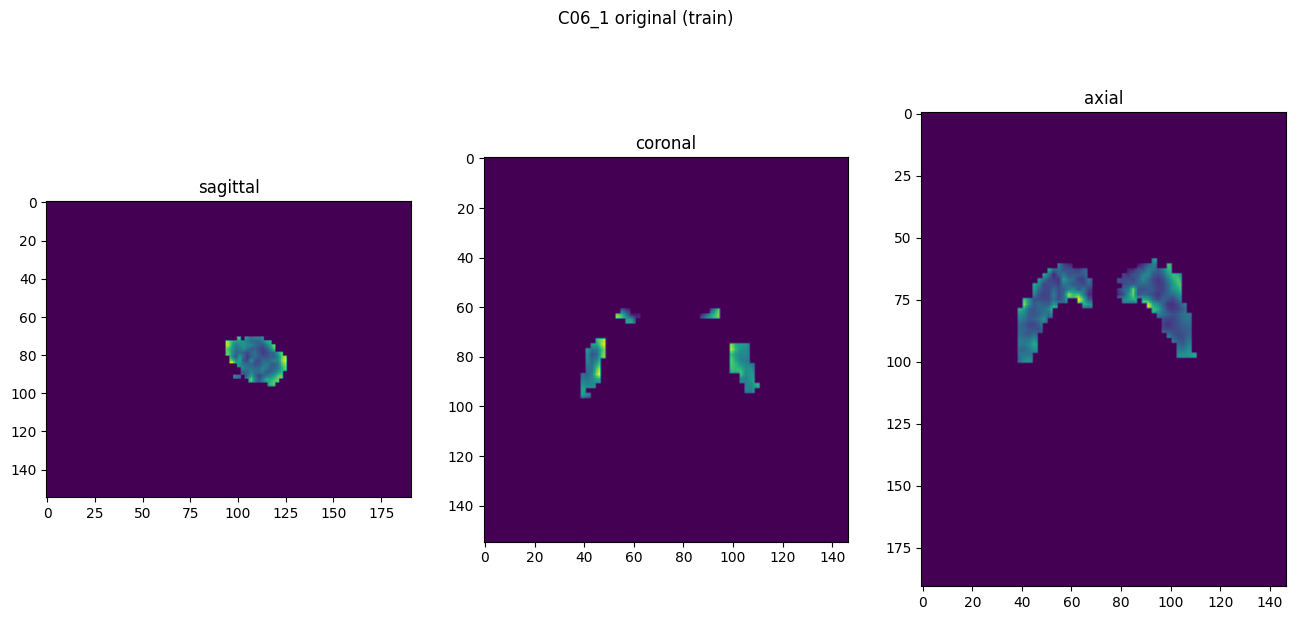

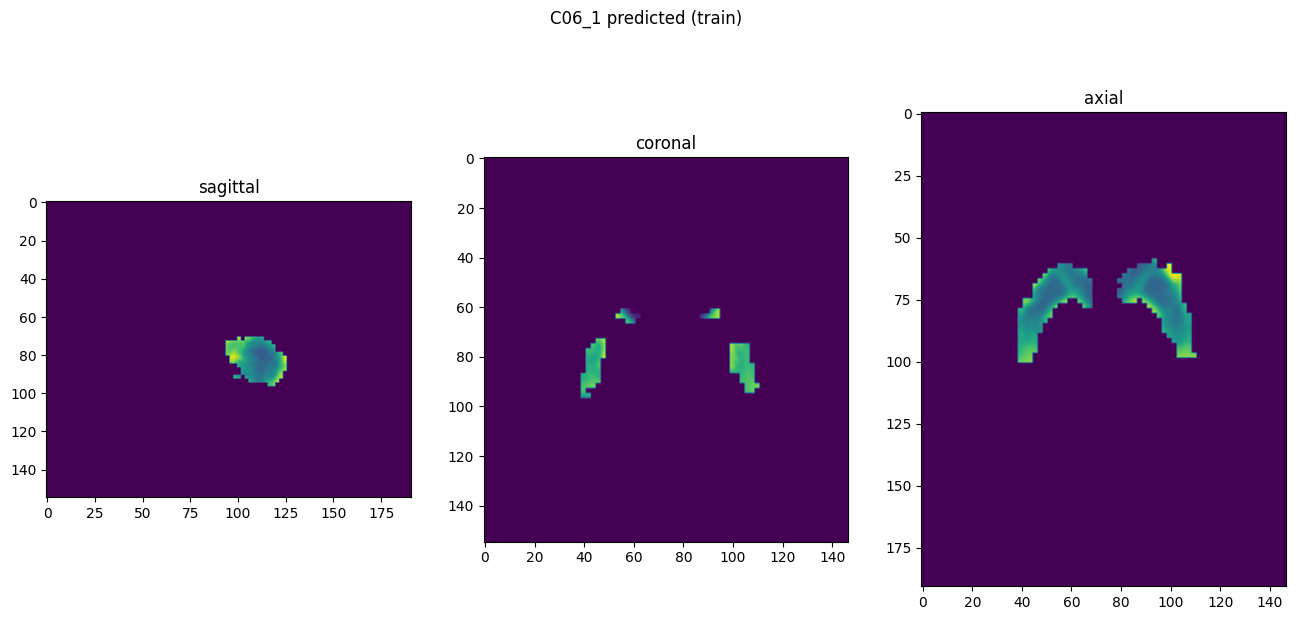

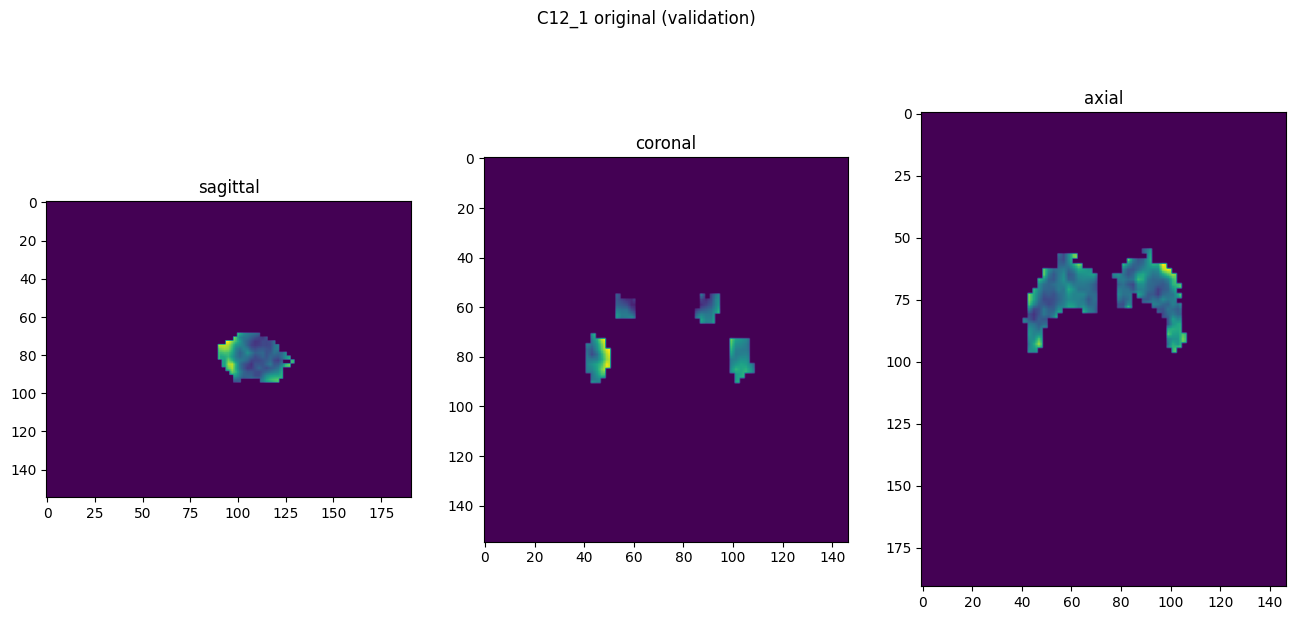

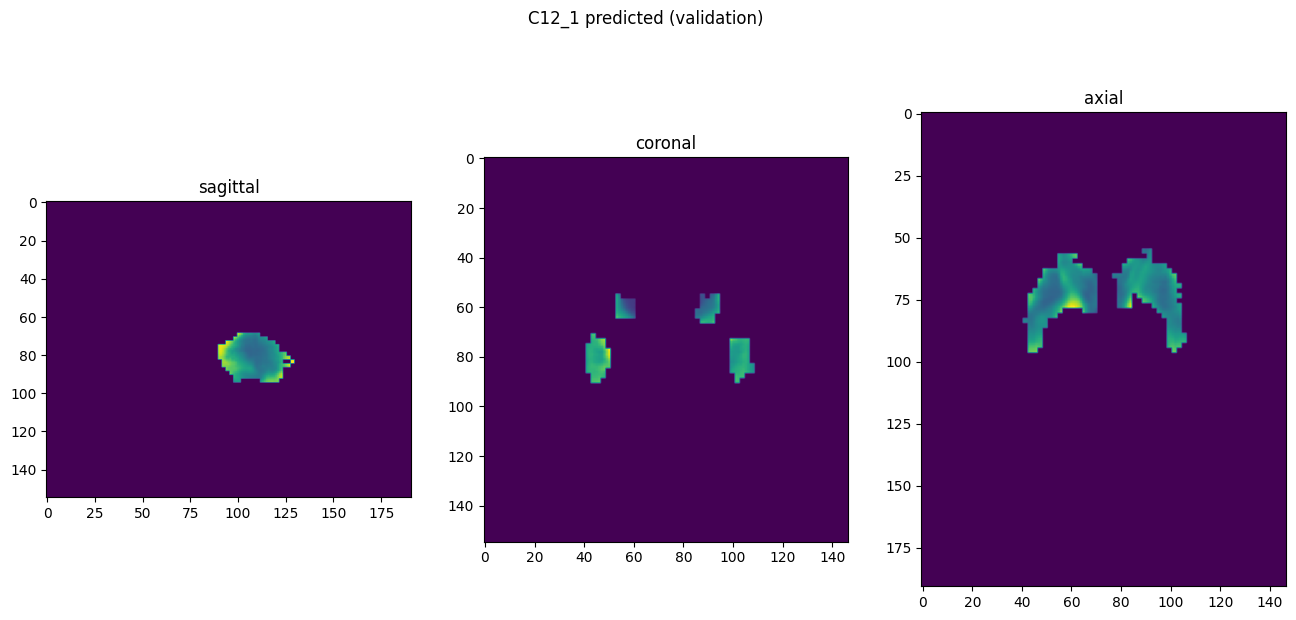

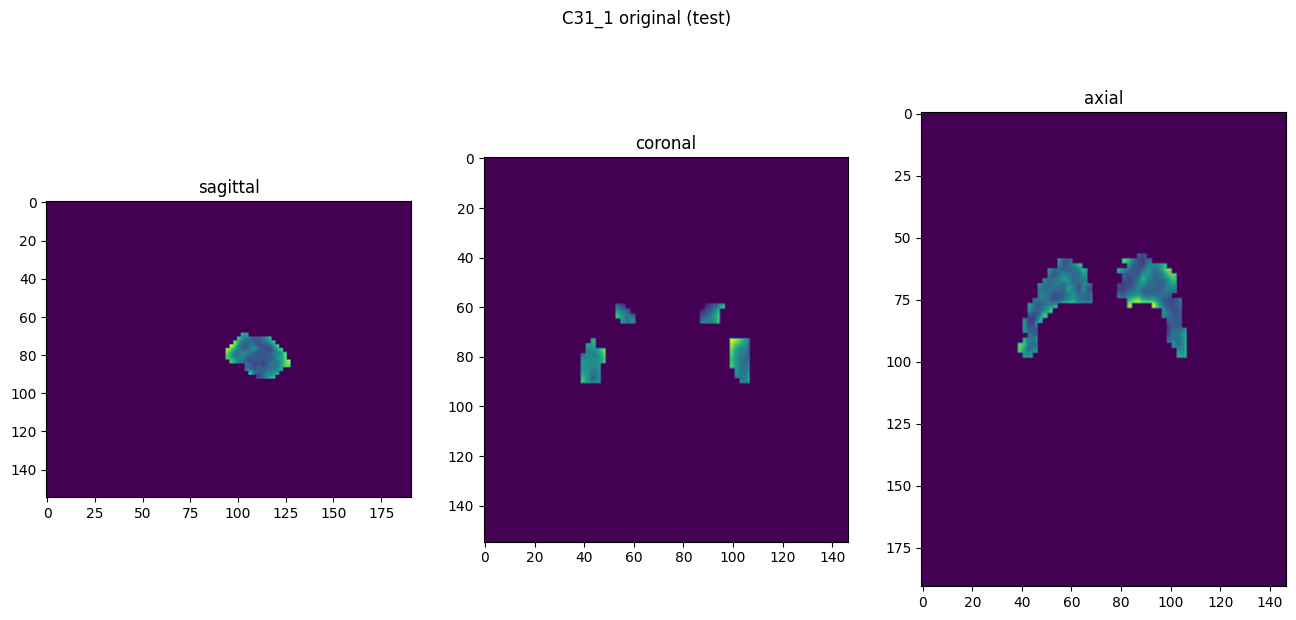

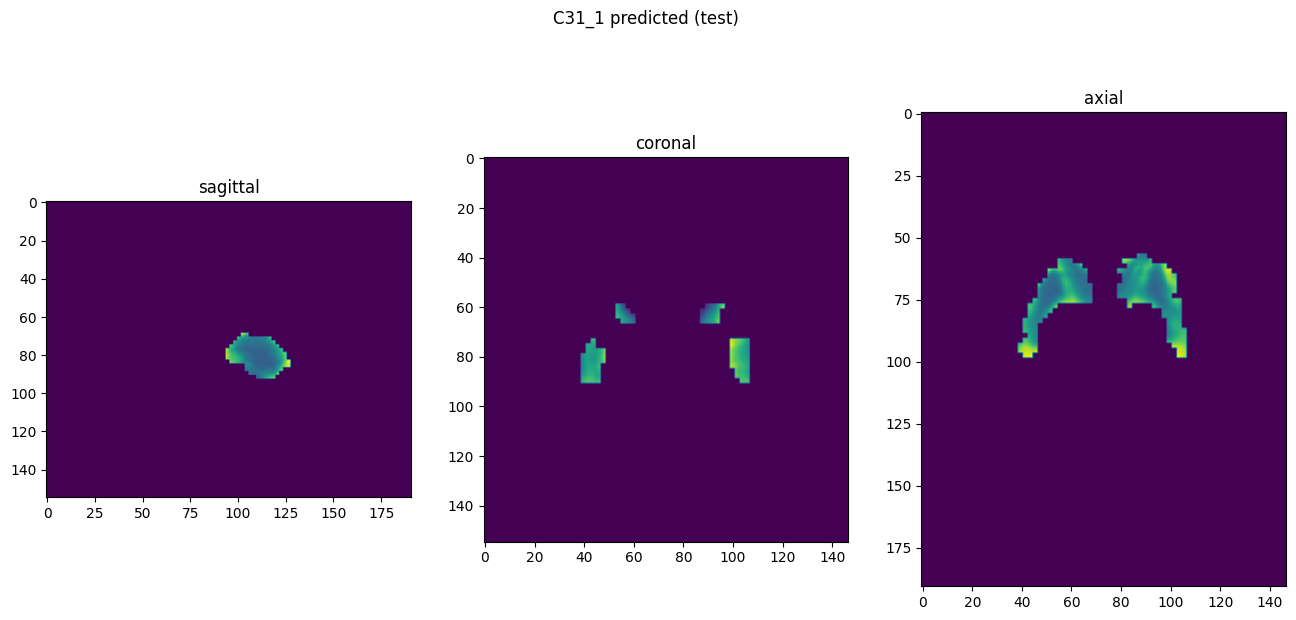

In [10]:
showResults(model, gen, threshold=None, background=False)